In [320]:
import graph_tool.all as gt
import string
import numpy as np
from random import choice, randint, random
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pylab import show, cm, axis
import seaborn as sns
import pandas as pd
import networkx as nx
from sklearn.preprocessing import normalize
from scipy.sparse import isspmatrix, dok_matrix, csc_matrix
import progressbar
%matplotlib inline

In [416]:
num_edges = 500
num_vertices = 100
ratios = [0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.2]

# letters = list(string.ascii_lowercase)
# letters_doubled = [i+i for i in letters]
# letters.extend(letters_doubled)

min_char = 8
max_char = 12
allchar = string.ascii_letters + string.digits
letters = sorted(["".join(choice(allchar) for x in range(randint(min_char, max_char))) for i in range(num_vertices)])

max_letters = len(letters)
def sample_letters(start: int=0, end: int=max_letters-1, ratio: float=0.1):
    a = [letters[i] for i in np.random.randint(start, end, int(ratio*num_edges))]
    aa = [letters[i] for i in np.random.randint(start, end, int(ratio*num_edges))]
    return a, aa

L = {"low": 0, "med": int(.1*num_vertices), "high": int(.2*num_vertices)}
R = {"low": int(.7*num_vertices), "med0": int(.8*num_vertices), "med1": int(.9*num_vertices), "high": num_vertices}

In [417]:
# Sample 50 letters from [a,b,c,d,e]
a, aa = sample_letters(L['low'],L['med'],ratios[0])
# Sample 50 letters from [f, g, h, i ,j]
b, bb = sample_letters(L['med'],L['high'],ratios[1])

# and so on ...
c, cc = sample_letters(L['low'],L['high'],ratios[2])

d, dd = sample_letters(R['med0'],R['med1'],ratios[3])
e, ee = sample_letters(R['low'],R['high'],ratios[4])
f, ff = sample_letters(R['med0'],R['high'],ratios[5])

g, gg = sample_letters(L['low'],R['high'],ratios[6])

In [418]:
first = pd.DataFrame(np.concatenate((a,b,c,d,e,f,g)))
second = pd.DataFrame(np.concatenate((aa,bb,cc,dd,ee,ff,gg)))
random_df = pd.concat([first, second], axis=1)
random_df.columns = ['src', 'dst']

random_df.head()

,src,dst
0,3rXFi4V0,9a5YyKrDg
1,9a5YyKrDg,93AgZzFgY
2,4mKglQwel,2fGPcHJ2eVe
3,2fGPcHJ2eVe,7jek7Z8rl2
4,4OzOFzSTH,6sZg2BTu2Ry


In [419]:
graph = gt.Graph(directed=False)
vertices = {}
vname = graph.new_vertex_property("string") 
graph.vp.name = vname
for vertex in set(np.concatenate((a,b,c,d,e,f,g,aa,bb,cc,dd,ee,ff,gg))):
    vertices[vertex] = graph.add_vertex()
    vname[graph.vertex_index[vertices[vertex]]] = vertex

In [420]:
def add_edge(row):
    if vertices[row['src']] == vertices[row['dst']] and \
        (vertices[row['src']] in graph.vertex(vertices[row['dst']]).out_neighbors() or \
        vertices[row['src']] in graph.vertex(vertices[row['dst']]).in_neighbors()):
        pass
    else:
        graph.add_edge(vertices[row['src']], vertices[row['dst']])

random_df.apply(add_edge, axis=1)
print(graph.get_out_degrees(graph.get_vertices()))
print(graph.vp.properties)

[ 4  2 28 17  2  1  3  3 12 20 19  9 20 14  1 16  3  1 24  2  2 17  3 31
 20  3  4  1  1 22 25  8  4 32 28  1 22 28 19  1  1  3  1  5  7 21  3 16
  2  4  8 24  1 10  1  2 23 23 15  4 22  2 20  1 18 26  3  1  2 16  2  1
 27 27 16 15  1  2  8  2  2  7 22 32 15  1  2 21  3  2  1 13]
{('v', 'name'): <PropertyMap object with key type 'Vertex' and value type 'string', for Graph 0x12babbb38, at 0x1268a75f8>}


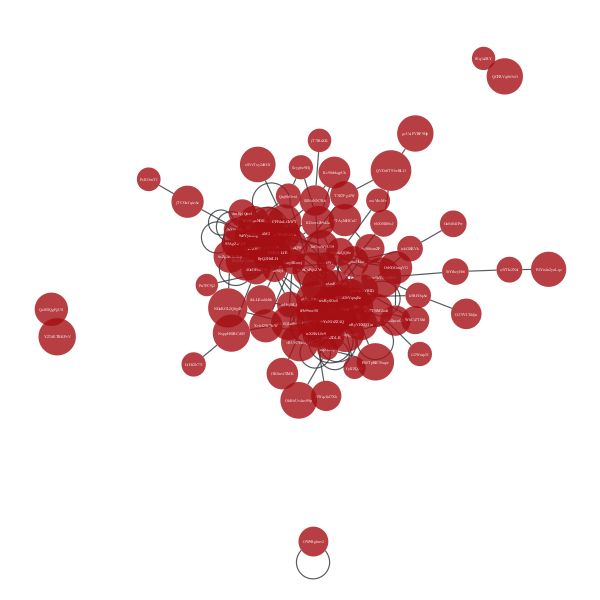

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12babbb38, at 0x12afe90b8>

In [421]:
pos = gt.sfdp_layout(graph)
gt.graph_draw(graph, pos=pos, vertex_text=vname, vcmap=cm.gist_heat_r, vertex_font_size=4,
              vertex_color=[1,1,1,0], vertex_size=1, edge_pen_width=1.2, output_size=(600, 600))

In [422]:
transition_matrix = gt.transition(graph)
adjacency_matrix = gt.adjacency(graph)

In [423]:
state = gt.minimize_blockmodel_dl(graph, B_max=3)
u = state.sample_graph(canonical=True, self_loops=False, multigraph=False)
ustate = gt.BlockState(u, b=state.b)

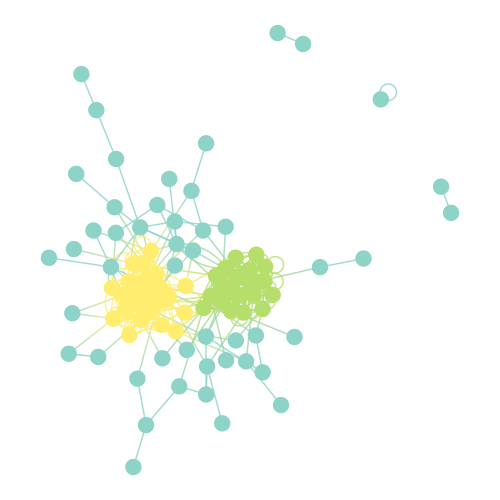

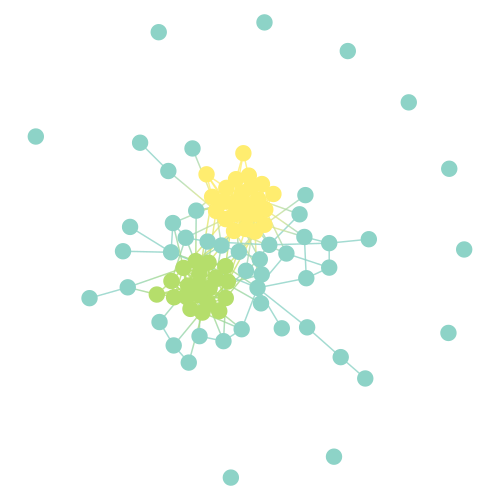

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12b040c88, at 0x12b032b70>

In [424]:
state.draw(output_size=(500, 500))
ustate.draw(output_size=(500, 500))

In [428]:
adjacency_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

In [433]:
def add_self_loop(matrix, loop_value):
    shape = matrix.shape
    assert shape[0] == shape[1], "Error, matrix is not square"
    if isspmatrix(matrix):
        new_matrix = matrix.todok()
    else:
        new_matrix = matrix.copy()
    for i in range(shape[0]):
        new_matrix[i, i] = new_matrix[i, i] if new_matrix[i, i]>0 else loop_value
    return new_matrix

def sparse_allclose(a, b, rtol=1e-5, atol=1e-8):
    """
    Version of np.allclose for use with sparse matrices
    """
    c = np.abs(a - b) - rtol * np.abs(b)
    # noinspection PyUnresolvedReferences
    return c.max() <= atol

def iterate(matrix, expansion, inflation):
    matrix = expand(matrix, expansion)
    matrix = inflate(matrix, inflation)
    return matrix

def expand(matrix, power):
    if isspmatrix(matrix):
        return matrix ** power
    return np.linalg.matrix_power(matrix, power)

def inflate(matrix, power):
    if isspmatrix(matrix):
        return normalize(matrix.power(power))
    return normalize(np.power(matrix, power), norm="l1", axis=0)
    
def prune(matrix, threshold):
    pruned = matrix.copy()
    pruned[pruned < threshold] = 0
    num_cols = matrix.shape[1]
    row_indices = matrix.argmax(axis=0).reshape((num_cols,))
    col_indices = np.arange(num_cols)
    pruned[row_indices, col_indices] = matrix[row_indices, col_indices]

    return pruned

def converged(matrix1, matrix2):
    if isspmatrix(matrix1) or isspmatrix(matrix2):
        return sparse_allclose(matrix1, matrix2)
    return np.allclose(matrix1, matrix2)

def get_clusters(matrix):
    if not isspmatrix(matrix):
        # cast to sparse so that we don't need to handle different 
        # matrix types
        matrix = csc_matrix(matrix)

    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]

    # somewhere to put the clusters
    clusters = set()

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))

def run_mcl(matrix, expansion=2, inflation=2, loop_value=1,
            iterations=100, pruning_threshold=0.001, pruning_frequency=1,
            convergence_check_frequency=1, verbose=False):
    
    if pruning_threshold > 0:
        print("Pruning threshold: {}, frequency: {} iteration{}".format(
            pruning_threshold, pruning_frequency, "s" if pruning_frequency > 1 else ""))
    else:
        print("No pruning")
    print("Convergence check: {} iteration{}".format(
        convergence_check_frequency, "s" if convergence_check_frequency > 1 else ""))
    print("Maximum iterations: {}".format(iterations))
    print("{} matrix mode".format("Sparse" if isspmatrix(matrix) else "Dense"))

    pb = progressbar.ProgressBar(maxval=iterations)
    pb.start()
    for i in range(iterations):
        last_mat = matrix.copy()
        matrix = iterate(matrix=matrix, expansion=2, inflation=2)

        if pruning_threshold > 0 and i % pruning_frequency == pruning_frequency - 1:
            matrix = prune(matrix, pruning_threshold)
        pb.update(value=i+1)
        if i % convergence_check_frequency == convergence_check_frequency - 1:
            if converged(matrix, last_mat):
                print("Converged after {} iteration{}".format(i + 1, "s" if i > 0 else ""))
                break
    return matrix

def plot_graph(matrix, clusters, figsize=(10,10), **kwargs):
    graph = nx.Graph(matrix)
    cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
    colors = [cluster_map[i] if i in cluster_map else -1 for i in range(len(graph.nodes()))]

    fig = plt.figure(figsize=figsize)
    nx.draw_networkx(graph, node_color=colors, **kwargs)
    axis("off")
    show(block=False)

In [388]:
# number of nodes to use
numnodes = 100

# generate random positions as a dictionary where the key is the node id and the value
# is a tuple containing 2D coordinates
positions = {i:(random() * 2 - 1, random() * 2 - 1) for i in range(numnodes)}

# use networkx to generate the graph
network = nx.random_geometric_graph(numnodes, 0.3, pos=positions)

# then get the adjacency matrix (in sparse form)
original_matrix = nx.to_scipy_sparse_matrix(network)

/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/usr/local/lib/python3.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Pruning threshold: 0.001, frequency: 1 iteration
Convergence check: 1 iteration
Maximum iterations: 100
Sparse matrix mode


Converged after 15 iterations


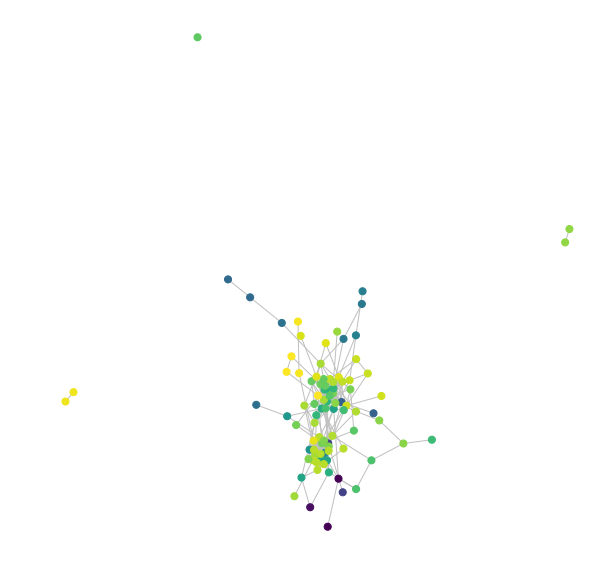

In [437]:
matrix = add_self_loop(matrix=adjacency_matrix, loop_value=1)
matrix = normalize(matrix, norm="l1", axis=0)
result = run_mcl(matrix, expansion=2, inflation=1.4)
clusters = get_clusters(matrix)
plot_graph(matrix=adjacency_matrix, clusters=clusters, node_size=50, with_labels=False, edge_color="silver")